<a href="https://colab.research.google.com/github/ankp6737/machinelearning/blob/main/Univariate_Time_Series_Prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [ ]:
import pandas as pd #import library that helps in data manipulation and analysis. This library will be referred as pd in future program
import numpy as np  #import library that is used for working with arrays
%matplotlib inline   
import matplotlib.pyplot as plt  #import library for plotting graphs

**Loading the Dataset**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/Product_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'    #
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


**Visualizing the Data**

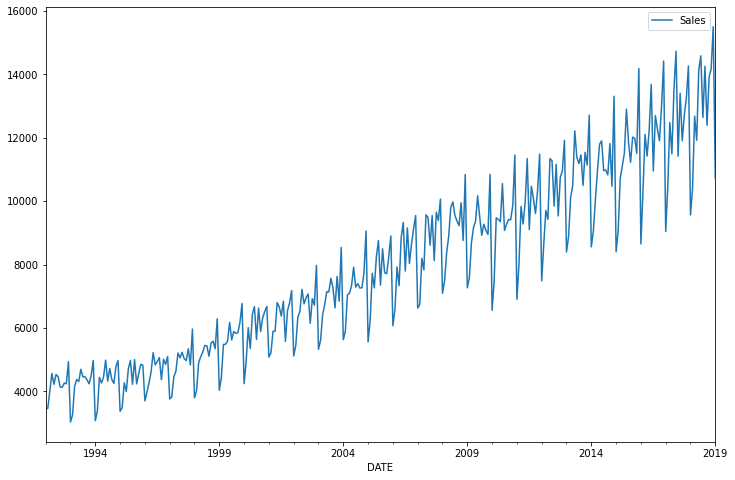

In [ ]:
df.columns = ['Sales']
df.plot(figsize=(12,8))

**Decomposing the Data**

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


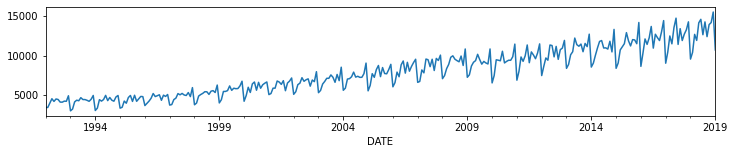

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df['Sales'],model='additive')
results.observed.plot(figsize=(12,2))

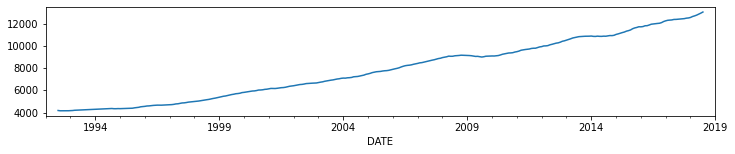

In [ ]:
results.trend.plot(figsize=(12,2))

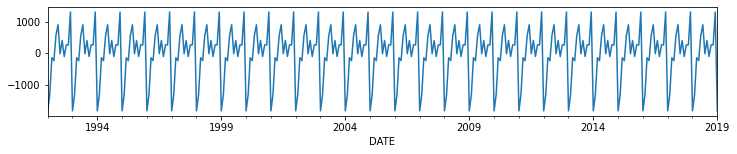

In [ ]:
results.seasonal.plot(figsize=(12,2))

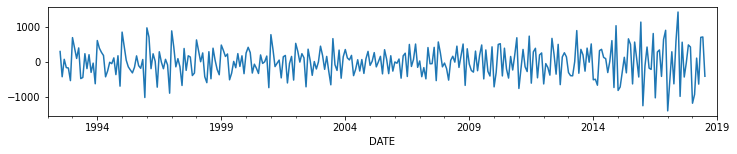

In [ ]:
results.resid.plot(figsize=(12,2))

**Splitting the data**

In [ ]:
print("len(df)", len(df))

train = df.iloc[:313]
test = df.iloc[313:]


print("len(train)", len(train))
print("len(test)", len(test))

len(df) 325
len(train) 313
len(test) 12


**Scaling the Data**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)   #Compute the minimum and maximum to be used for later scaling.

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled_train = scaler.transform(train)    #	Scale features of train according to feature_range.
scaled_test = scaler.transform(test)      #	Scale features of test according to feature_range.

**Generating Time Series Data**

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
scaled_train[0]

array([0.03658432])

In [ ]:
# define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

print('len(scaled_train)',len(scaled_train))
print('len(generator)',len(generator))  # n_input = 2

len(scaled_train) 313
len(generator) 311


**Visualizing the time series generated data**

In [ ]:
# What does the first batch look like?
X,y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03658432 0.03649885]
Predict this y: 
 [[0.08299855]]


In [ ]:
# Let's redefine to get 12 months back and then predict the next month out
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

# What does the first batch look like?
X,y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03658432 0.03649885 0.08299855 0.13103684 0.1017181  0.12804513
 0.12266006 0.09453799 0.09359774 0.10496624 0.10334217 0.16283443]
Predict this y: 
 [[0.]]


**Defining the Model**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


**Training the Model**

In [ ]:
# fit model
model.fit_generator(generator,epochs=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
301/301 [==============================] - 3s 6ms/step - loss: 0.0291
Epoch 2/50
301/301 [==============================] - 2s 7ms/step - loss: 0.0113
Epoch 3/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0099
Epoch 4/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0078
Epoch 5/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0090
Epoch 6/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0064
Epoch 7/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0057
Epoch 8/50
301/301 [==============================] - 2s 7ms/step - loss: 0.0037
Epoch 9/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0033
Epoch 10/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0035
Epoch 11/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0028
Epoch 12/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0023
Epoch 13/50
301/301 [====

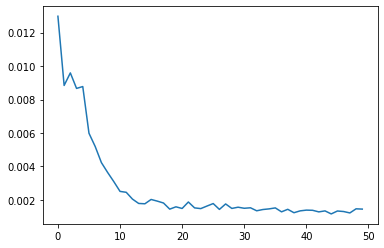

In [ ]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

**Evaluate on Test Data**

In [ ]:
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [ ]:
scaled_test[0]

array([0.63116506])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
test_predictions

[array([0.7486957], dtype=float32),
 array([0.85607916], dtype=float32),
 array([0.8199184], dtype=float32),
 array([0.9871027], dtype=float32),
 array([1.052259], dtype=float32),
 array([0.8008259], dtype=float32),
 array([0.9651167], dtype=float32),
 array([0.81942046], dtype=float32),
 array([0.9135949], dtype=float32),
 array([0.94476926], dtype=float32),
 array([1.0267282], dtype=float32),
 array([0.6484812], dtype=float32)]

In [ ]:
scaled_test

array([[0.63116506],
       [0.82502778],
       [0.75972305],
       [0.94939738],
       [0.98743482],
       [0.82135225],
       [0.95956919],
       [0.80049577],
       [0.93025045],
       [0.95247457],
       [1.0661595 ],
       [0.65706471]])

**Inverse Transformations and Compare**

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[11789.99066156],
       [13046.27010649],
       [12623.22529244],
       [14579.11433941],
       [15341.37767076],
       [12399.86213249],
       [14321.90003544],
       [12617.39992511],
       [13719.14675337],
       [14083.85561097],
       [15042.69266462],
       [10617.5814442 ]])

In [ ]:
test['Predictions'] = true_predictions
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Sales,Predictions
DATE,,
2018-02-01,10415,11789.990662
2018-03-01,12683,13046.270106
2018-04-01,11919,12623.225292
2018-05-01,14138,14579.114339
2018-06-01,14583,15341.377671
2018-07-01,12640,12399.862132
2018-08-01,14257,14321.900035
2018-09-01,12396,12617.399925
2018-10-01,13914,13719.146753


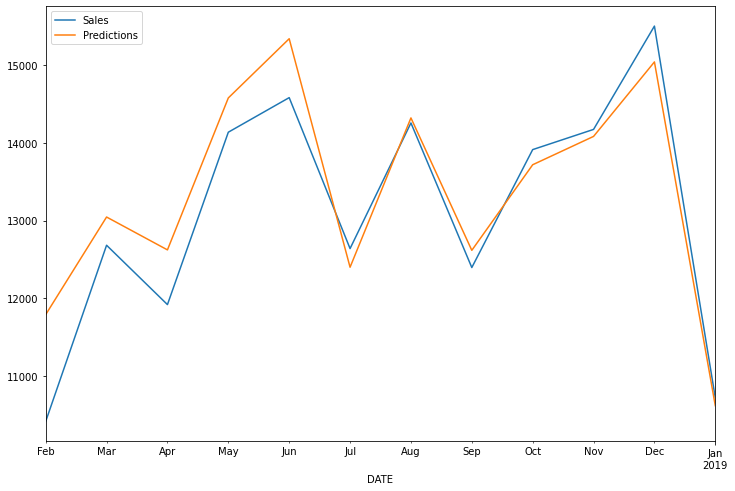

In [ ]:
test.plot(figsize=(12,8))

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(test['Sales'], test['Predictions'])
r2  

0.8659715435075135